In [12]:
import os
print(os.getcwd())

C:\cygwin64\home\mpatnam\CSCIE63\Project


In [13]:
###### README ######
### Data Columns in the xlsx file - sheet 0 ###
# col1 Date
# col2 Open
# col3 High
# col4 Low
# col5 Close
# col6 Volume
# col7 Adj Close     (Y)
# col8 Sentiment Score1   (X)  Dictionary approach
# col9 Sentiment Score2   (X)  Naive Bayes approach

# Predict Close Price (Y) using Sentiment Scores (X)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = 'SentimentVsClosePrices.AAPL.xlsx'
STOCK = 'AAPL'
#DATA_FILE = 'SentimentVsClosePrices.FB.xlsx'
#STOCK = 'FB'
#DATA_FILE = 'SentimentVsClosePrices.TSLA.xlsx'
#STOCK = 'TSLA'

# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override="utf-8")
sheet = book.sheet_by_index(0)
n_samples = sheet.nrows - 1
print('total samples: {0}'.format(n_samples))

# Step 2: use 80% of data for training, remaining for test.
train_samples = int(0.8*n_samples)
train_data = np.asarray([sheet.row_values(i) for i in range(1, train_samples)])
test_samples = n_samples - train_samples
test_data = np.asarray([sheet.row_values(i) for i in range(train_samples+1, n_samples)])

# train samples
print('\nnumber of train samples: {0}'.format(train_samples))
print('Train sample: {0}'.format(train_data[0]))

# test samples
print('\nnumber of test samples: {0}'.format(test_samples))
print('Test sample: {0}'.format(test_data[0]))

total samples: 42

number of train samples: 33
Train sample: [  4.27950000e+04   1.37889999e+02   1.40149994e+02   1.37600006e+02
   1.39789993e+02   3.64146000e+07   1.39789993e+02   3.59000000e-03
   0.00000000e+00   2.30000000e+01]

number of test samples: 9
Test sample: [  4.28430000e+04   1.41410004e+02   1.42039993e+02   1.41110001e+02
   1.41199997e+02   1.46608000e+07   1.41199997e+02   1.00900000e-02
   0.00000000e+00   4.35000000e+02]


In [2]:
# Step 3: create placeholders for input Y (Aggregate Sentiment Score) and label X (Close Price)
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

print(X)
print(Y)

# Step 4: create weight and bias, initialized to 0
w = tf.Variable(0.0, name='weights_1')
b = tf.Variable(0.0, name='bias')

print(w)
print(b)

# Step 5: build model to predict Y
##Y_predicted = tf.matmul(X, w) + b
Y_predicted = (X * w) + b 
print(Y_predicted)

Tensor("X:0", dtype=float32)
Tensor("Y:0", dtype=float32)
Tensor("weights_1/read:0", shape=(), dtype=float32)
Tensor("bias/read:0", shape=(), dtype=float32)
Tensor("add:0", dtype=float32)


In [3]:
# Step 6: use the square error as the loss function
loss = tf.square(Y - Y_predicted, name='loss')
tf.summary.scalar("loss", loss)

learning_rate = 0.0001
# Step 7: using gradient descent with the configured learning rate to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [4]:
train_times=1000  # train the model 1000 times
   
with tf.Session() as sess:
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer()) 
    writer = tf.summary.FileWriter('C:/cygwin64/home/mpatnam/CSCIE63/Project/tensorboard/'+STOCK+'.regression', sess.graph)
    
    # Collect all summary Ops in graph
    summ = tf.summary.merge_all()
    # tf.summary.histogram("weights", w)

    # Step 8: train the model
    for i in range(train_times):
        total_loss = 0
        # x: SentimentScore
        # y: ClosePrice
        for n, _, _, _, _, _, y, x, _, _ in train_data:
            # Session runs train_op and fetch values of loss
            #print('n:{0}, x:{1}, y:{2}'.format(n, x, y))
            _, l, s = sess.run([optimizer, loss, summ], feed_dict={X: x, Y:y}) 
            total_loss += l

        print('Average Loss epoch {0}: {1}'.format(i, total_loss/n_samples))
        if i % 10 == 0:
            writer.add_summary(s, i)

    # close the writer when you're done using it
    writer.close() 

    # Step 9: output the values of w and b
    w_value, b_value = sess.run([w, b]) 

Average Loss epoch 0: 15119.075939360118
Average Loss epoch 1: 14926.764601934523
Average Loss epoch 2: 14736.899646577382
Average Loss epoch 3: 14549.45033482143
Average Loss epoch 4: 14364.385416666666
Average Loss epoch 5: 14181.675734747023
Average Loss epoch 6: 14001.290225074405
Average Loss epoch 7: 13823.198567708334
Average Loss epoch 8: 13647.37341889881
Average Loss epoch 9: 13473.78515625
Average Loss epoch 10: 13302.405459449405
Average Loss epoch 11: 13133.20545014881
Average Loss epoch 12: 12966.158854166666
Average Loss epoch 13: 12801.236886160714
Average Loss epoch 14: 12638.4130859375
Average Loss epoch 15: 12477.660551525298
Average Loss epoch 16: 12318.953171502977
Average Loss epoch 17: 12162.265043712798
Average Loss epoch 18: 12007.569893973214
Average Loss epoch 19: 11854.842796688989
Average Loss epoch 20: 11704.058686755952
Average Loss epoch 21: 11555.19275483631
Average Loss epoch 22: 11408.220540364584
Average Loss epoch 23: 11263.119884672618
Average Loss

In [5]:
# calculate squared value (for RMSE purpose) given a predicted and actual value
def squared_error(pred, actual):
    return (pred - actual) ** 2

# Step 8: report results
print('Weight:{0}'.format(w_value))
print('Bias: %2.5f' % b_value)

#access test columns
X, Y = test_data.T[7], test_data.T[6]
print('Test Sentiment Scores: {0}'.format(X))

Y_predicted_test = X * w_value + b_value
print('Predicted Close Price using test data:{0}'.format(Y_predicted_test))
print('Actual Close Price:{0}'.format(Y))

# measure RMSE accuracy
accuracy_rmse = np.sqrt(squared_error(Y_predicted_test, Y).mean())
print('Model accuracy using RMSE: ', accuracy_rmse)

Weight:-1.8761721849441528
Bias: 141.03577
Test Sentiment Scores: [ 0.01009 -0.0343  -0.03518 -0.0207  -0.03843 -0.00984 -0.02089 -0.00961]
Predicted Close Price using test data:[ 141.01683602  141.10011931  141.10177034  141.07460337  141.1078679
  141.05422814  141.07495984  141.05379662]
Actual Close Price:[ 141.199997  140.679993  142.440002  142.270004  143.639999  144.529999
  143.679993  143.789993]
Model accuracy using RMSE:  2.12707369846


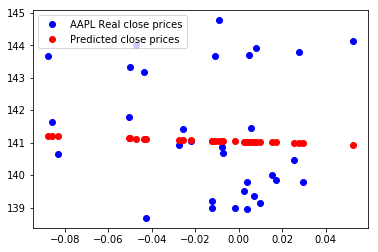

In [6]:
# plot the results
X, Y = train_data.T[7], train_data.T[6]
plt.plot(X, Y, 'bo', label=STOCK+' Real close prices')
plt.plot(X, (X * w_value) + b_value, 'ro', label='Predicted close prices')
plt.legend()
plt.show()